In [7]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import pickle

import pyproj
from pyproj import Geod
from pyproj import Proj, transform
from fiona.crs import from_epsg
from osgeo import osr

# To get the groups, run 
```python
import netCDF4
fp='ATL15_AA_0311_01km_001_01.nc'
nc = netCDF4.Dataset(fp)
nc
```

In [8]:
src_path = "ATL15_AA_0311_01km_001_01.nc"
ds = xr.open_dataset(src_path, group='delta_h')

In [9]:
for j in range(0, len(ds['time']) - 1):
    dt = ds['time'][j+1] - ds['time'][j]
    print(float(dt.values) * 1.15741e-14) # Print delta t in days

91.31270454
91.31270454
91.31270454
91.31270454
91.31270454
91.31270454
91.31270454
91.31270454
91.31270454
91.31270454
91.31270454


In [10]:
indf = 4
ind0 = 0
dh = ds['delta_h'][indf,:,:] - ds['delta_h'][ind0,:,:]
grounded_mask = np.load("grounded-mask/grounded_mask.npy")
grounded_mask = xr.DataArray(data=np.flipud(grounded_mask), dims=["y", "x"], coords=[ds['y'],ds['x']])
dh = dh * grounded_mask

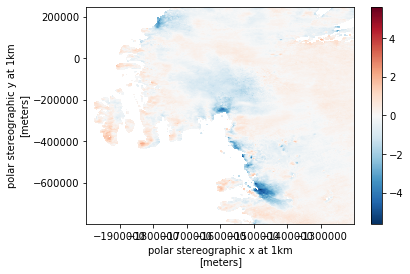

In [11]:
# # Alpine3D region
# x_min = -1540e3
# x_max = -1380e3
# y_min = -110e3
# y_max = 0

# Coastal West Antarctica
x_min = -2000e3
x_max = -1200e3
y_min = -800e3
y_max = 250e3

# # Interior 
# x_min = -500e3
# x_max = -260e3
# y_min = -500e3
# y_max = 500e3

# # Larger West Antarctica
# x_min = -2000e3
# x_max = -500e3
# y_min = -1500e3
# y_max = 500e3

x1_ind = (ds['x'] > x_min)
x2_ind = (ds['x'] < x_max)
x_ind = np.logical_and(x1_ind, x2_ind)

y1_ind = (ds['y'] > y_min)
y2_ind = (ds['y'] < y_max)
y_ind = np.logical_and(y1_ind, y2_ind)
dh_zone = dh[y_ind, x_ind]
dh_zone.plot()

# Save lat/lon array

In [12]:
# Get source x and y
src_x = dh_zone['x']
src_y = dh_zone['y']

# Create meshgrid then squash to a vector
src_x, src_y = np.meshgrid(src_x, src_y)
src_x = src_x.flatten()
src_y = src_y.flatten()

# Convert x and y vector to lat/lon vector
src = osr.SpatialReference()
tgt = osr.SpatialReference()
src.ImportFromEPSG(3031) # South Polar Stereo
tgt.ImportFromEPSG(4326) # WGS 84

# Define transformation
transform = osr.CoordinateTransformation(src, tgt)

# Initialize arrays
tgt_lon = np.zeros(len(src_x)); tgt_lon[:] = np.nan
tgt_lat = np.zeros(len(src_x)); tgt_lat[:] = np.nan

# Perform transformation
for j in range(0, len(tgt_lon)):
    coords = transform.TransformPoint(src_x[j], src_y[j])
    tgt_lat[j], tgt_lon[j] = coords[0:2]
    
# Compile into array and save
lat_lon = np.transpose(np.stack([tgt_lat, tgt_lon]))
print(lat_lon.shape)

# Save array
np.savetxt("IC2_lat_lon.txt", lat_lon)

# Save shape
shape = dh_zone.shape
with open('ATL15_shape.pkl', 'wb') as f:
    pickle.dump(shape, f)

(838151, 2)


# Open inference array and format for visualization

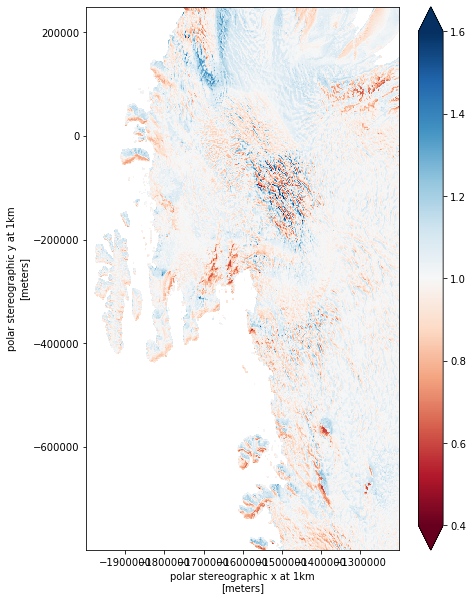

In [13]:
# Plot the ratio
ratio = np.loadtxt("ratio.txt")
ratio = np.reshape(ratio, dh_zone.shape)
ratio = xr.DataArray(data=ratio, dims=["y", "x"], coords=[dh_zone['y'], dh_zone['x']])
ratio = ratio * grounded_mask
plt.figure(figsize=(7, 10))
ratio.plot(cmap=plt.cm.RdBu, vmin=0.4, vmax=1.6)

inference = np.loadtxt("Inference_Y.txt")
inference = np.reshape(inference, dh_zone.shape)
inference = xr.DataArray(data=inference, dims=["y", "x"], coords=[dh_zone['y'], dh_zone['x']])
inference = inference * grounded_mask
dh_corr = dh_zone - inference

# Visualize change in surface height and change in FAC

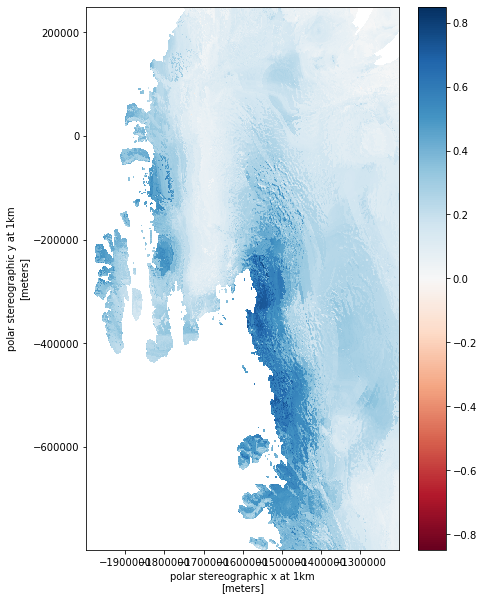

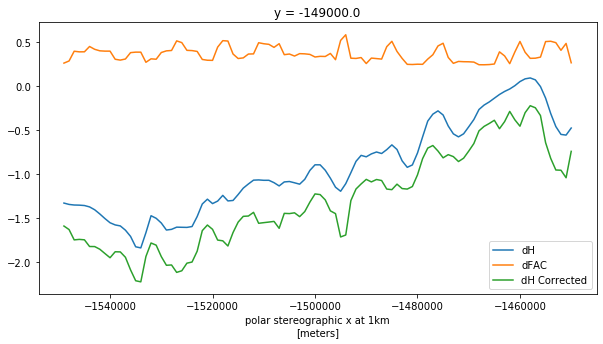

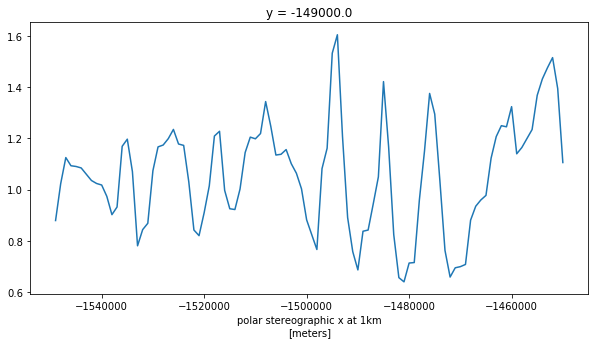

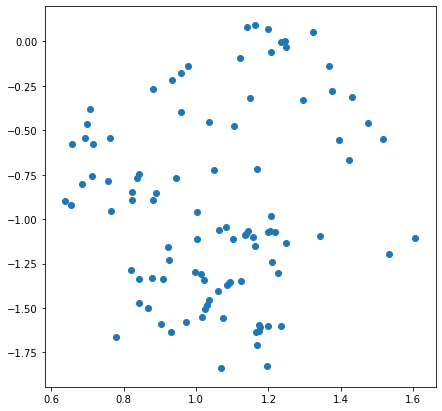

In [14]:
plt.figure(figsize=(7, 10))
inference.plot(cmap=plt.cm.RdBu)

plt.figure(figsize=(10, 5))
y_ind = 650
x_inds = np.arange(450, 550)
dh_zone[y_ind,x_inds].plot(label='dH')
inference[y_ind,x_inds].plot(label='dFAC')
dh_corr[y_ind,x_inds].plot(label='dH Corrected')
# dh_zone[y_ind,:].plot(label='dH')
# inference[y_ind,:].plot(label='dFAC')
# dh_corr[y_ind,:].plot(label='dH Corrected')
plt.legend()

plt.figure(figsize=(10, 5))
ratio[y_ind,x_inds].plot()

plt.figure(figsize=(7, 7))
plt.scatter(ratio[y_ind,x_inds], dh_zone[y_ind,x_inds])

Initial time: 2018-10-01T22:30:00.000000000
Final time: 2019-10-02T04:30:00.000000000

****** No GIA correction has been applied ******
Regional Mass balance = -148.36602227121966 Gt
****** No GIA correction has been applied ******

Delta H Variance: 0.30857036 m^2
Firn Corrected Delta H Variance: 0.3632609210274462 m^2
Variance Reduction: -17.723856142681793 %


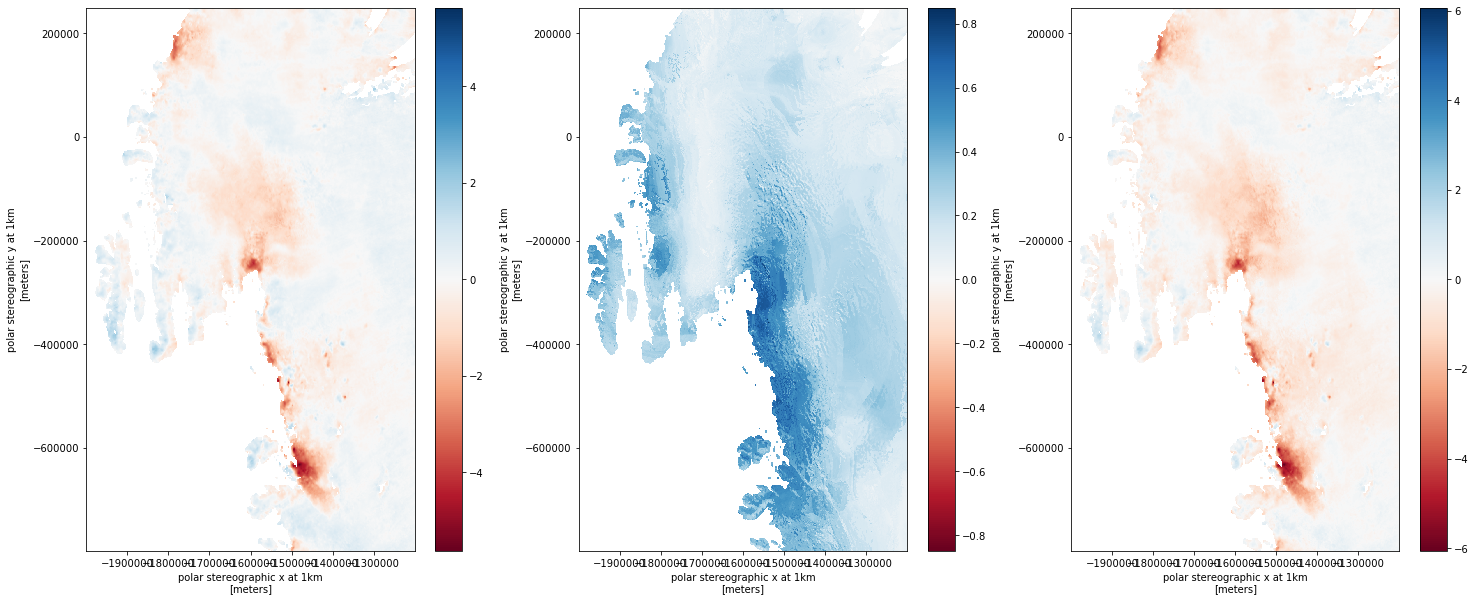

In [15]:
# Plot
lim = np.nanmax(np.abs(inference))
fig, axes = plt.subplots(ncols=3, figsize=(25, 10))
dh_zone.plot(cmap=plt.cm.RdBu, ax=axes[0])
inference.plot(cmap=plt.cm.RdBu, ax=axes[1], vmin=-lim, vmax=lim)
dh_corr.plot(cmap=plt.cm.RdBu, ax=axes[2])

# Print initial and final date
print("Initial time: " + str(ds['time'][ind0].values))
print("Final time: " + str(ds['time'][indf].values))

# Regional mass balance
MB = 917 * dh_corr * ds['cell_area']
MB = MB.sum() / 1e12
print()
print("****** No GIA correction has been applied ******")
print("Regional Mass balance = " + str(MB.values) + " Gt")
print("****** No GIA correction has been applied ******")


# Calculate variance reduction
vr = 1 - (dh_corr.var() / dh_zone.var())
print()
print("Delta H Variance: " + str(dh_zone.var().values) + " m^2")
print("Firn Corrected Delta H Variance: " + str(dh_corr.var().values) + " m^2")
print("Variance Reduction: " + str(100*vr.values) + " %")

In [16]:
# io = np.loadtxt("inference.txt")
# diff = io[:,2] / io[:,3] # Mean precip - mean precip over 91 days
# diff = np.reshape(diff, dh_zone.shape)
# diff = xr.DataArray(data=diff, dims=["y", "x"], coords=[dh_zone['y'], dh_zone['x']])
# diff = diff * grounded_mask
# plt.figure(figsize=(7, 10))
# lim = np.max(np.abs(diff))
# diff.plot(cmap=plt.cm.RdBu, vmin=-lim, vmax=lim)

# Plot the inputs

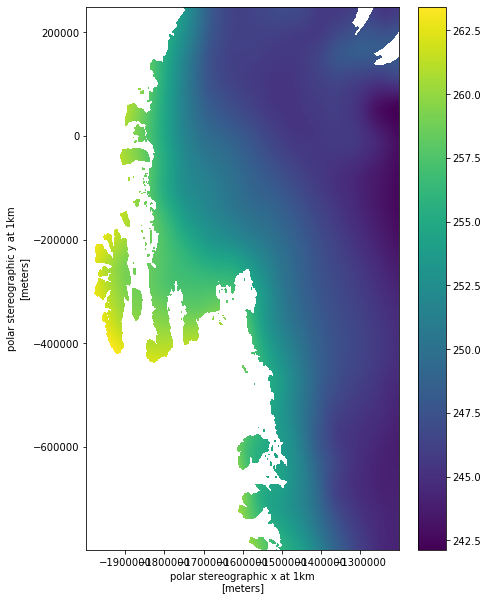

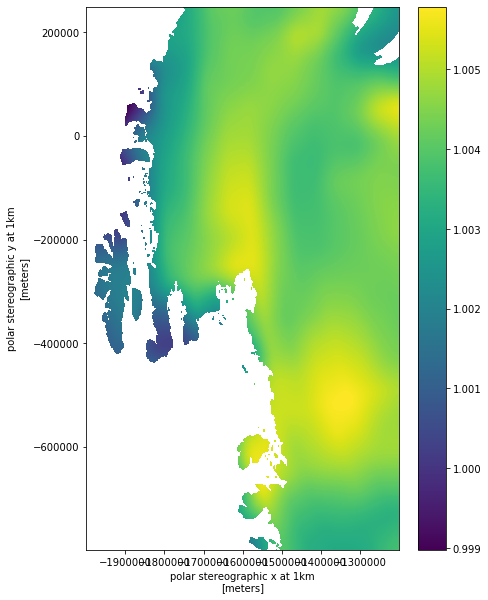

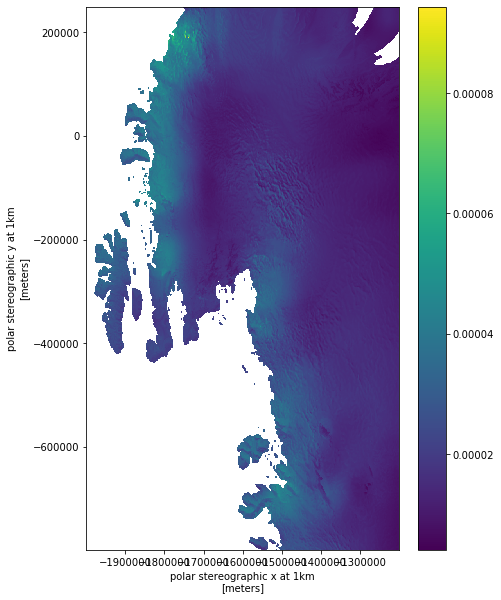

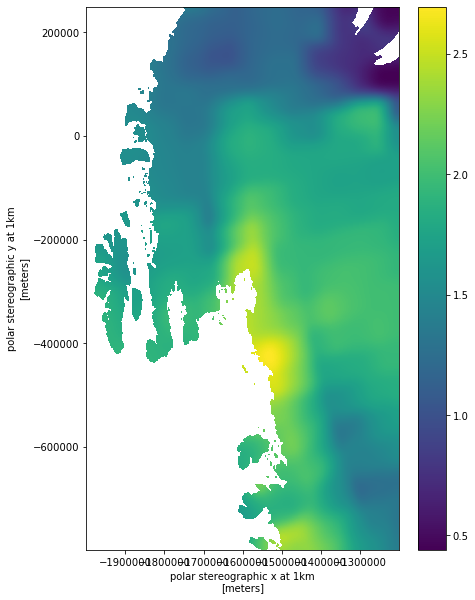

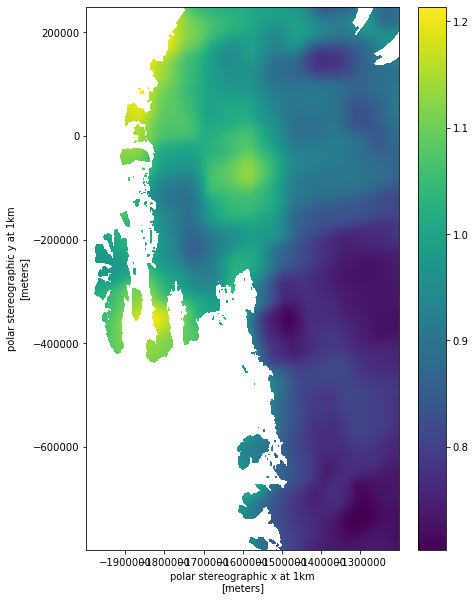

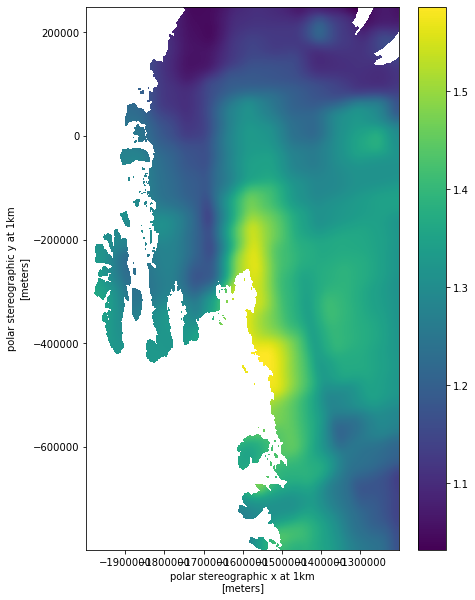

In [17]:
io = np.loadtxt("inference.txt")
for j in range(0, io.shape[1]):
# for j in range(2, 3): # Plot a precip map

    im = np.reshape(io[:,j], dh_zone.shape)
    im = xr.DataArray(data=im, dims=["y", "x"], coords=[dh_zone['y'], dh_zone['x']])
    im = im * grounded_mask
    plt.figure(figsize=(7, 10))
    im.plot()

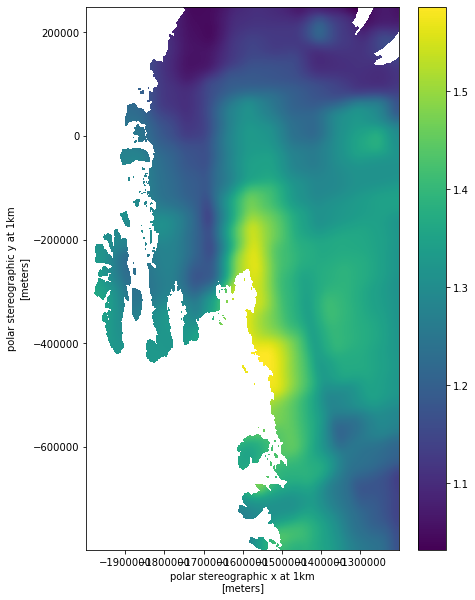

In [18]:
plt.figure(figsize=(7, 10))
im.plot()